In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DuSzeTeng\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DuSzeTeng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
!pip install transformers

In [3]:
# upload the dataset

dataset = pd.read_csv('Review.csv', header=None)

In [4]:
# load the pre-trained model (BERT)

# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
# model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)


In [5]:
# use the trained distilBERT to generate sentence embeddings

tokenizer.encode('A lot of bright and scholar students have studied here. BA with leading research team with a modern lab facilities. Students from around the globe study here.', add_special_tokens=True)

[101,
 1037,
 2843,
 1997,
 4408,
 1998,
 6288,
 2493,
 2031,
 3273,
 2182,
 1012,
 8670,
 2007,
 2877,
 2470,
 2136,
 2007,
 1037,
 2715,
 6845,
 4128,
 1012,
 2493,
 2013,
 2105,
 1996,
 7595,
 2817,
 2182,
 1012,
 102]

In [6]:
# Build the dataset

#  tokenize the sentences -- break them up into word and subwords in the format BERT prefers. This turns every sentence into the list of ids.

tokenized = dataset[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
print(tokenized)

0      [101, 1037, 2843, 1997, 4408, 1998, 6288, 2493...
1      [101, 1045, 2572, 16054, 2075, 15038, 2085, 19...
2      [101, 1045, 2031, 2908, 2013, 2383, 5717, 7023...
3      [101, 2009, 2038, 2042, 2107, 1037, 6919, 1998...
4      [101, 1996, 7224, 1999, 2267, 2003, 2307, 1025...
                             ...                        
507                  [101, 5409, 8902, 20679, 1012, 102]
508                         [101, 5409, 3325, 2412, 102]
509    [101, 5409, 2082, 1045, 2031, 2412, 2464, 1996...
510    [101, 2017, 2191, 2204, 2814, 4089, 2182, 1998...
511    [101, 1060, 2495, 1010, 2026, 5440, 2082, 999,...
Name: 0, Length: 512, dtype: object


In [7]:
# Padding - make all the vectors the same size

max_len = 0
for i in tokenized:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized])

np.array(padded).shape

(512, 140)

In [8]:
# Masking - create another variable to tell it to ignore (mask) the padding we've added when it's processing its input.

attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(512, 140)

In [9]:
# run the model and show last hidden states

input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

print(last_hidden_states)

BaseModelOutput(last_hidden_state=tensor([[[ 2.9023e-02, -2.0292e-01, -3.2254e-01,  ..., -2.9170e-01,
           6.0461e-01, -5.9440e-02],
         [ 6.3830e-04, -8.2153e-02, -4.3273e-01,  ..., -4.2001e-01,
           7.6665e-01, -4.3452e-02],
         [ 4.2992e-01, -1.9376e-01,  1.8070e-01,  ..., -4.1114e-01,
           4.9630e-01, -3.9836e-01],
         ...,
         [ 5.7604e-01,  2.4728e-01,  2.9399e-01,  ..., -1.5780e-01,
           2.3892e-01, -4.2280e-01],
         [ 4.5114e-01,  1.7504e-01,  3.5096e-01,  ..., -2.0002e-01,
           3.7291e-01, -5.0394e-01],
         [ 1.2527e-02, -4.4351e-02,  2.5624e-01,  ..., -1.6991e-01,
           4.1464e-01, -5.1884e-01]],

        [[ 1.4917e-01,  1.0024e-01,  1.4665e-01,  ..., -1.0511e-01,
           4.0846e-01,  1.2842e-01],
         [ 4.4537e-01,  5.1938e-02,  9.8941e-02,  ..., -2.4625e-01,
           6.7515e-01, -1.9671e-02],
         [ 1.6391e-01,  4.9534e-01,  4.5502e-01,  ..., -2.3075e-01,
           3.7305e-01,  2.0456e-01],
     

In [10]:
# save the features variable for logistic regression model

features = last_hidden_states[0][:,0,:].numpy()
features.shape

(512, 768)

In [11]:
# split our datset into a training set (80%) and testing set (20%)

labels = dataset[1]
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [12]:
# Check class distribution
print(train_labels.value_counts())

1
1    288
0     96
Name: count, dtype: int64


In [13]:
# Grid Search for Parameters
parameters = {'C': np.linspace(0.0001, 100, 20)}
# Set cv to a number less than the smallest class count or use a different cross-validation strategy
grid_search = GridSearchCV(LogisticRegression(), parameters, cv=3)  # Adjust cv as needed
grid_search.fit(train_features, train_labels)

print('best parameters: ', grid_search.best_params_)
print('best scrores: ', grid_search.best_score_)

best parameters:  {'C': 5.263252631578947}
best scrores:  0.9322916666666666


In [14]:
lr_clf = LogisticRegression(C=5.263252631578947)
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=5.263252631578947)

In [15]:
lr_clf.score(test_features, test_labels)

0.9375

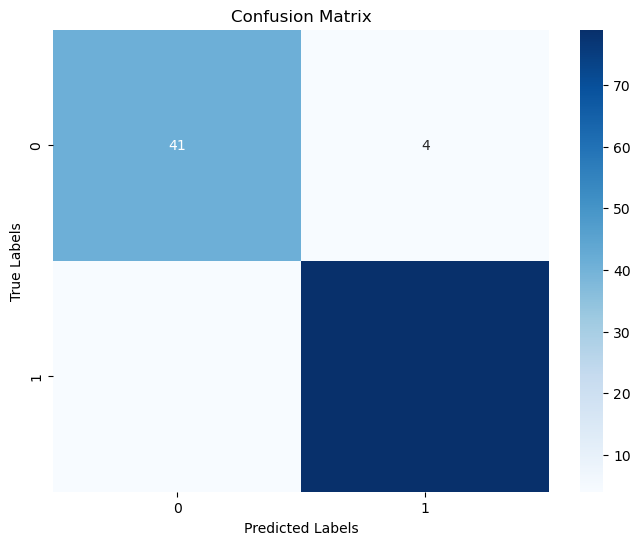

              precision    recall  f1-score   support

           0       0.91      0.91      0.91        45
           1       0.95      0.95      0.95        83

    accuracy                           0.94       128
   macro avg       0.93      0.93      0.93       128
weighted avg       0.94      0.94      0.94       128



In [16]:
# draw a confusion maxtrix report based on above result

# Predict labels for test data
y_pred = lr_clf.predict(test_features)


# Generate confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(test_labels, y_pred))

In [17]:
# test the prediction with new test review

# Add a text to test the prediction
text = "The school is great"  # Replace with your text

# Tokenize and preprocess the text
tokenized_text = tokenizer.encode(text, add_special_tokens=True)
padded_text = np.array([tokenized_text + [0]*(max_len-len(tokenized_text))])
attention_mask_text = np.where(padded_text != 0, 1, 0)

input_ids_text = torch.tensor(padded_text)
attention_mask_text = torch.tensor(attention_mask_text)

# Generate embeddings for the text
with torch.no_grad():
    last_hidden_states_text = model(input_ids_text, attention_mask=attention_mask_text)

features_text = last_hidden_states_text[0][:,0,:].numpy()

# Predict sentiment
prediction = lr_clf.predict(features_text)

print("Predicted Sentiment:", prediction[0])


Predicted Sentiment: 1


In [18]:
# test the prediction with new test review

# Add a text to test the prediction
text = "The school is bad"  # Replace with your text

# Tokenize and preprocess the text
tokenized_text = tokenizer.encode(text, add_special_tokens=True)
padded_text = np.array([tokenized_text + [0]*(max_len-len(tokenized_text))])
attention_mask_text = np.where(padded_text != 0, 1, 0)

input_ids_text = torch.tensor(padded_text)
attention_mask_text = torch.tensor(attention_mask_text)

# Generate embeddings for the text
with torch.no_grad():
    last_hidden_states_text = model(input_ids_text, attention_mask=attention_mask_text)

features_text = last_hidden_states_text[0][:,0,:].numpy()

# Predict sentiment
prediction = lr_clf.predict(features_text)

print("Predicted Sentiment:", prediction[0])

Predicted Sentiment: 0


In [19]:
# prompt: to create topic modeling for positive review

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Filter for positive reviews
positive_reviews = dataset[dataset[1] == 1][0].tolist()

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(positive_reviews)

# Apply LDA for topic modeling
num_topics = 5  # Adjust the number of topics as needed
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Display topics and their top words
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
collage students course amazing study work education student highly enjoy
Topic 1:
collage course best students good professor canteen professors business learning
Topic 2:
course students skills opportunities practical learning apply provided excellence develop
Topic 3:
school good best staff teachers student faculty excellent management friendly
Topic 4:
great staff course college professors teaching helpful good best education


In [20]:
# prompt: to create topic modeling for negative review

# Filter for negative reviews
negative_reviews = dataset[dataset[1] == 0][0].tolist()

# Vectorize the text data
vectorizer_neg = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_neg = vectorizer_neg.fit_transform(negative_reviews)

# Apply LDA for topic modeling (adjust num_topics as needed)
lda_neg = LatentDirichletAllocation(n_components=5, random_state=42)
lda_neg.fit(X_neg)

# Display topics and their top words for negative reviews
display_topics(lda_neg, vectorizer_neg.get_feature_names_out(), no_top_words)


Topic 0:
money fee students time form education online increase year admission
Topic 1:
fees food collage options expensive campus difficulty did way orientation
Topic 2:
school expensive course costly fee money bad education long courses
Topic 3:
collage fees expensive academic management money cost education professors pathetic
Topic 4:
fee expensive financial course structure register aid extorbitant worth exorbitant


In [21]:
# define top 20 words appearance most in negative review 
# removing stop words, punctuation, and common words


# Filter for negative reviews
negative_reviews = dataset[dataset[1] == 0][0].tolist()

# Combine all negative reviews into a single string
all_negative_text = ' '.join(negative_reviews)

# Tokenize and remove punctuation
tokens = word_tokenize(all_negative_text.lower())
tokens = [word for word in tokens if word.isalnum()]

# Remove stop words and common words
stop_words = set(stopwords.words('english'))
common_words = {'school', 'collage', 'course', 'education','students','campus','said'}
filtered_tokens = [word for word in tokens if word not in stop_words and word not in common_words]

# Count word frequencies
word_counts = Counter(filtered_tokens)

# Get the top 20 most frequent words (without counts)
top_20_words = [word for word, count in word_counts.most_common(20)]

print(top_20_words)

['expensive', 'fee', 'fees', 'money', 'financial', 'costly', 'food', 'cost', 'go', 'bad', 'register', 'structure', 'online', 'professors', 'increase', 'options', 'form', 'time', 'aid', 'admission']


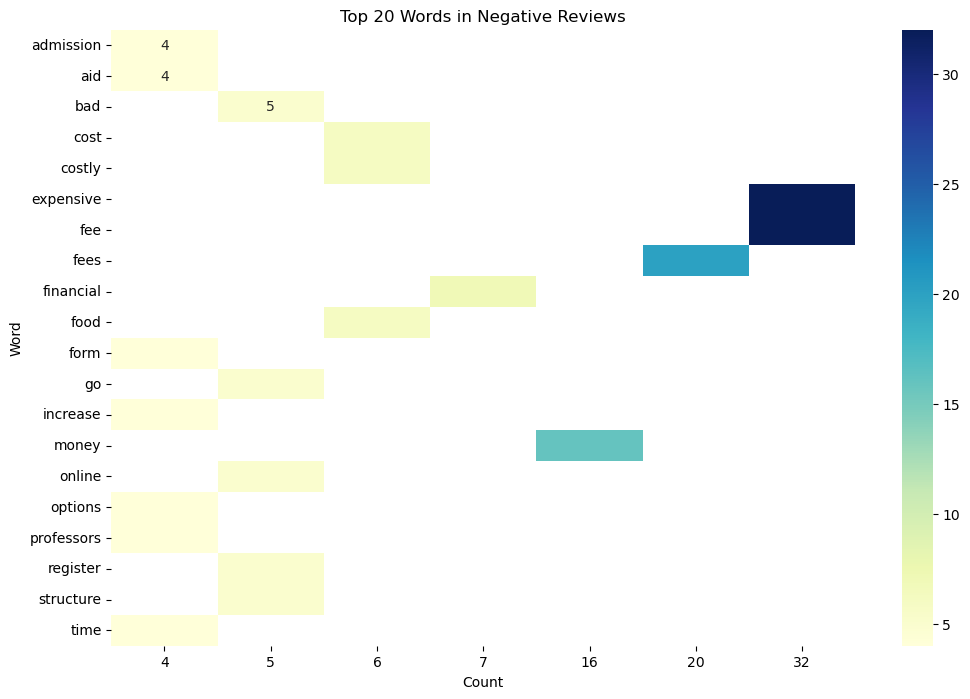

In [22]:
# draw a heatmap for top 20 words in negative review

# Create a DataFrame for the heatmap
df_top_words = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Count'])

# Pivot the DataFrame for the heatmap
df_heatmap = df_top_words.pivot(index='Word', columns='Count', values='Count')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_heatmap, cmap="YlGnBu", annot=True, fmt=".0f") # Use fmt=".0f" to format floats as integers without decimals
plt.title('Top 20 Words in Negative Reviews')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

In [23]:
# define top 20 key wowrds from positive review
# removing stop words, punctuation, and common words

# Filter for positive reviews
positive_reviews = dataset[dataset[1] == 1][0].tolist()

# Combine all positive reviews into a single string
all_positive_text = ' '.join(positive_reviews)

# Tokenize and remove punctuation
tokens = word_tokenize(all_positive_text.lower())
tokens = [word for word in tokens if word.isalnum()]

# Remove stop words and common words
stop_words = set(stopwords.words('english'))
common_words = {'school', 'collage', 'college','course', 'education','student','campus','said','also','x','one', 'study' , 'students'}  # Add more common words as needed
filtered_tokens = [word for word in tokens if word not in stop_words and word not in common_words]

# Count word frequencies
word_counts = Counter(filtered_tokens)

# Get the top 20 most frequent words (without counts)
top_20_words = [word for word, count in word_counts.most_common(20)]

print(top_20_words)


['good', 'best', 'great', 'professors', 'learning', 'staff', 'excellent', 'faculty', 'teachers', 'skills', 'academic', 'amazing', 'environment', 'highly', 'supportive', 'professor', 'experience', 'management', 'provided', 'teaching']


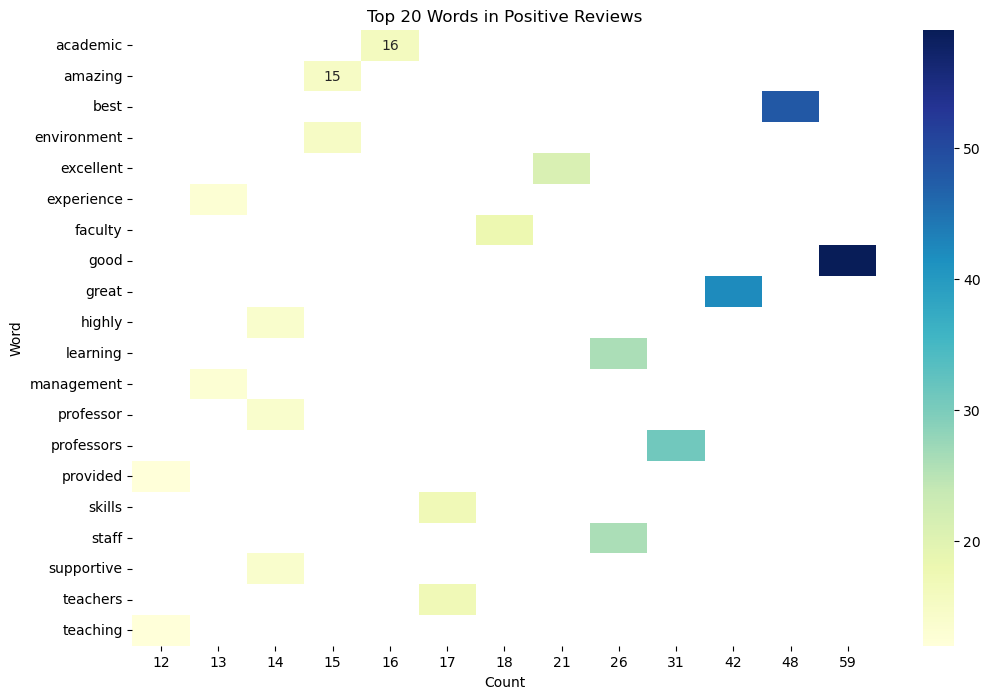

In [24]:
# draw heatmap for top 20 

# Create a DataFrame for the heatmap
df_top_words = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Count'])

# Pivot the DataFrame for the heatmap
df_heatmap = df_top_words.pivot(index='Word', columns='Count', values='Count')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_heatmap, cmap="YlGnBu", annot=True, fmt=".0f") # Use fmt=".0f" to format floats as integers without decimals
plt.title('Top 20 Words in Positive Reviews')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()
